In [1]:
import numpy as np
import pandas as pd
import os
import subprocess
import time
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy

from rdkit import Chem
import ase
from ase.io import read, write
from ase.units import Hartree
from ase.visualize import view

from ase.io.trajectory import Trajectory
import glob
import pickle

In [2]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

In [3]:
# Read Dataframe containing entire chemical space
path = os.getcwd() + '/data/'
file = 'df_chemical_space_chons_4rings.json'
p = pd.read_json(path+file, orient='split')

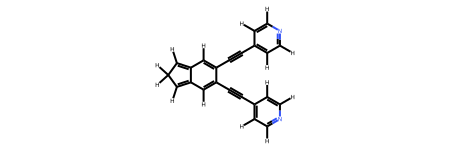

In [195]:
# Pick a random molecule in the space and get its smile string
rand_i = np.random.randint(315451)
# rand_i = 308345
# rand_i = 183692 # Debug Error....
# rand_i = 48234 # No heteroatoms
# smi = p.iloc[rand_i]['molecule_smiles']

# Draw chem
rdkit_smi = Chem.AddHs(Chem.MolFromSmiles(smi))
rdkit_smi

In [ ]:
p.iloc[rand_i]

------

In [4]:
os.chdir('run')

In [5]:
from osc_discovery.photocatalysis.adsorption.tools import prepare_substrate
from osc_discovery.photocatalysis.adsorption.optimal_configurations import find_optimal_adsorbate_configurations_sequential, relax_all_adsorbate_configurations, check_site_identity_volatilization
from osc_discovery.photocatalysis.thermodynamics.tools import single_run, multi_run
from osc_discovery.photocatalysis.thermodynamics.tools import calculate_free_energies, free_energy_diagram
from osc_discovery.photocatalysis.thermodynamics.constants import WATER_OXIDATION_POTENTIAL, SHE_VACUUM_POTENTIAL, IPEA_EMPIRICAL_SHIFT

In [ ]:
def calculate_single_molecule_properties(smile_string):
    # Generate conformers, optimize with FF, and then optimize geometry of lowest energy conf with xTB
    substrate, substrate_confs = prepare_substrate(smile_string)
    
    ### 1. Suitability as a photocatalyst and absorber
    
    # Determine IP/EA/HOMO/LUMO of the substrate
    IP, EA, ehomo, elumo = ipea(substrate, substrate.info['calc_params'])
    
    # Implicit Solvation? 
    
    # Potentially do a cheap TDDFT calculation with sTDA
    EA_excited, IP_excited, optical_gap
    
    # Correct these values to B3LYP level using calibration curve
    
    # Properties of interest
    fund_gap = (IP - EA) # Fundamental gap = optical + exciton binding energy
    hole_redox_potential = IP / 1. - SHE_VACUUM_POTENTIAL
    
    ### 2. Suitability as an electrocatalyst
    
    intermediate_configs = find_optimal_adsorbate_configurations(substrate)
    dGs = calculate_free_energies(substrate, *intermediate_configs)
    theoretical_water_redox_potential = dGs.max() + WATER_OXIDATION_POTENTIAL
    
    driving_potential = (hole_redox_potential - theoretical_water_oxidation_potential)
    
    print("E°(H2O/O2) + η (V):", theoretical_water_redox_potential)
    print("Hole redox potential (V):", hole_redox_potential)
    print("Photocatalyst capable water oxidation?", driving_potential > 0)
    #free_energy_diagram(dGs)

-----

#### Sequential active site search

In [ ]:
cs = find_optimal_adsorbate_configurations_sequential(sub, optlevel_low='normal', optlevel_high='vtight', keep_folders=True, multi_process=6)

In [ ]:
cs = multi_run(cs, runtype='hess', calc_kwargs=calc_params, multi_process=3)
gs = calculate_free_energies(sub, *cs)
gs

In [ ]:
free_energy_diagram(gs)

----


Testing with ASE and LFBGS

In [ ]:
from osc_discovery.photocatalysis.adsorption.constants import OH, O, OOH
from osc_discovery.photocatalysis.adsorption.building import build_configuration_from_site
from xtb.ase.calculator import XTB
from ase.optimize import LBFGS

In [ ]:
configsO = []
for site in range(sub.info['nonH_count']):
    configsO += build_configuration_from_site(O, sub, site, f=1.4)
    
for j, config in enumerate(configsO):
    config.calc = XTB(accuracy=0.2, electronic_temp=298.15)
    dyn = LBFGS(config, trajectory=f'opt_{j}.traj')
    dyn.run(fmax=0.05)

-----

Radical Thermochemistry

In [ ]:
# OH.write('OH.xyz'), O.write('O.xyz'), OOH.write('OOH.xyz')

In [ ]:
# gfn=2, acc=0.2, uhf=1, etemp=298.15
eoh_radical = -4.428374966658 * Hartree
eo_radical = -3.769421097051 * Hartree
eooh_radical = -8.459628268501 * Hartree

In [ ]:
# Standard entropies taken from NIST (orginally in J/mol/K, converted to eV/atom)
soh_radical = 183.71 * 298.15 / 1.60217e-19 / 6.02214e23 
so_radical = 161.059 * 298.15 / 1.60217e-19 / 6.02214e23
sooh_radical = 229.09 * 298.15 / 1.60217e-19 / 6.02214e23

In [ ]:
TS_H2_g = 0.41
TS_H2O_g = 0.67

TS1 = (0.5 * TS_H2_g - TS_H2O_g)
TS2 = 0.5 * TS_H2_g
TS3 = (0.5 * TS_H2_g - TS_H2O_g)
TS4 = (2 * TS_H2O_g - 3/2 * TS_H2_g)

In [ ]:
deoh = eoh - eoh_radical - es
dsoh = soh - soh_radical - ss
dgoh = deoh - dsoh

In [ ]:
deo = eo - eo_radical - es
dso = so - so_radical - ss
dgo = deo - dso

In [ ]:
deooh = eooh - eooh_radical - es
dsooh = sooh - sooh_radical - ss
dgooh = deooh - dsooh

In [ ]:
abs(dgoh).argmin(), abs(dgo).argmin(), abs(dgooh).argmin()

If were simply looking for the optimal active sites of OH, O, and OOH radical adsorption on the substrate, they would be the near zero free energy changes given above... neither too strongly, nor too weakly. The situation above is completely analogous to the HER mechanism:

H+ + e- + * -> *H     OR     1/2 H2 + * -- *H

The optimal catalyst for this step in the HER, is the one where ΔGads = G(*H) - G(1/2 H2) - G(*) ~ 0!

But in the context of water splitting, there are other reactants/products during each step in the mechanism that changes the calculus of what makes a good active site... ΔGads (bimolecular or dissociative adsorption) has to balance the ΔG of formation of 1/2 H2 gas and the consumption H2O gas, such that the resulting free energy change of the entire step, is as close to the ideal value (in this case 1.23eV)

In [ ]:
def pairwise_differences(a, b, k=0, flatten=False):
    assert len(b) == len(a), 'Arrays must be of equal length! fill with nans'
    # Unique Pair wise differences of two vectors (b-a) given by the Upper triangular matrix
    # of the difference of (N, 1) and (1, N) vectors with numpy broadcasting
    pwd_square = b[:, None] - a
    
    if not flatten:
        # Upper triangle
        # Fill lower triangle (made of 0's) with nans
        # k=0, includes diagonal | k=1 disregards it
        pwd = np.triu(pwd_square, k=k)
        pwd[pwd==0.] = np.nan
    
    else:
        # Return upper triangular part in flattened array
        uniq_diff_matrix = np.triu_indices(len(a), k=k)
        pwd = pwd_square[uniq_diff_matrix]
    
    return pwd

In [ ]:
def fill_na(a, b):
    len_diff = len(a) - len(b)
    if len_diff > 0:
        new_b = np.append(b, len_diff * [np.nan])
        return a, new_b
    elif len_diff < 0:
        new_a = np.append(a, -len_diff * [np.nan])
        return new_a, b
    else:
        return a, b

In [ ]:
def clean_configs(configs):
    # Take a list of configs and resort them according to active
    # Also remove duplicate active sites, keeping lowest energy ones
    # d = dict.fromkeys([i for i in range(sub.info['nonH_count'])], np.nan)
    cs = deepcopy(configs)

    for config in cs:
        actv = config.info['active_site']
        if actv in d and d[actv]:
            if config.info['energy'] < d[actv].info['energy']:
                d[actv] = config
        else:
            d[actv] = config

    return list(d.values())

In [ ]:
def clean_configs_with_nans(configs):
    # Take a list of configs and resort them according to active
    d = dict.fromkeys([i for i in range(sub.info['nonH_count'])], np.nan)
    cs = deepcopy(configs)

    for config in cs:
        actv = config.info['active_site']
        d[actv] = config

    return list(d.values())

------------

In [ ]:
from osc_discovery.photocatalysis.adsorption.optimal_configurations import filter_configurations
from osc_discovery.photocatalysis.thermodynamics.constants import dG1_CORRf, dG2_CORRf, dG3_CORRf, dG4_CORRf

In [16]:
calc_params_new = {'gfnff':'', 'acc':0.2, 'etemp':298.15}
subf, sub_confsf = prepare_substrate(smi, calc_params_new)

Number of rotatable bonds: 0, C(#Cc1cc2c(cc1C#Cc1ccncc1)=CCC=2)c1ccncc1
1) Embedding conformers (50). Using 1 processes
Took: 2.203059196472168 s
2) Minimizing 50 conformers (mmff94)
Took: 1.705512285232544 s
3) Pruning conformers (RMSD threshold: 0.35 Ang)
Took: 0.3326101303100586 s
Number of conformers found: 4


In [17]:
sub_newf = single_run(subf, runtype='vipea')
ipshef = sub_newf.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
ipshef

2.8359999999999994

----

In [21]:
def group_by_activesite(egfn, agfn, eff, aff):
    Es_grouped = []
    for e, a in zip(egfn, agfn):
        if a in aff:
            indx = aff.tolist().index(a)
            Es_grouped.append([e, eff[indx]])
            
    return np.array(Es_grouped)

#### Brute active site search

In [13]:
from scipy.spatial.distance import pdist, squareform
from itertools import product, repeat
from collections import OrderedDict
from math import prod

In [7]:
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'strict':''}
sub, sub_confs = prepare_substrate(smi, calc_params)

Number of rotatable bonds: 0, C(#Cc1cc2c(cc1C#Cc1ccncc1)=CCC=2)c1ccncc1
1) Embedding conformers (50). Using 1 processes
Took: 2.2168304920196533 s
2) Minimizing 50 conformers (mmff94)
Took: 1.7244970798492432 s
3) Pruning conformers (RMSD threshold: 0.35 Ang)
Took: 0.36763477325439453 s
Number of conformers found: 4


In [8]:
sub_new = single_run(sub, runtype='vipea', **calc_params)

In [9]:
ipshe = sub_new.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
ipshe

2.7695999999999996

In [ ]:
rc = relax_all_adsorbate_configurations(sub, calc_params, optlevel='vtight', keep_folders=False, multi_process=6)

In [ ]:
rc_vib = []
for intermediate in rc:
    rc_vib.append(multi_run(intermediate, runtype='hess', calc_kwargs=calc_params, multi_process=6))

In [6]:
# with open('complete_run5.pckl', 'wb') as f:
#     pickle.dump([smi, rc_vib[0], rc_vib[1], rc_vib[2]], f)

rc_vib = 3*[np.nan]
with open('complete_run5.pckl', 'rb') as f:
    smi, rc_vib[0], rc_vib[1], rc_vib[2]  = pickle.load(f)

In [10]:
oh = deepcopy(rc_vib[0])
o = deepcopy(rc_vib[1])
ooh = deepcopy(rc_vib[2])

In [11]:
es = sub.info['energy']
zpes = sub.info['zpe']
hs = sub.info['enthalpy']
ss = sub.info['entropy']
fs = sub.info['free_energy']

asoh = np.array([config.info['active_site'] if config is not np.nan else np.nan for config in oh])
aso = np.array([config.info['active_site'] if config is not np.nan else np.nan for config in o])
asooh = np.array([config.info['active_site'] if config is not np.nan else np.nan for config in ooh])

eoh = np.array([config.info['energy'] if config is not np.nan else np.nan for config in oh])
eo = np.array([config.info['energy'] if config is not np.nan else np.nan for config in o])
eooh = np.array([config.info['energy'] if config is not np.nan else np.nan for config in ooh])

zpeoh = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in oh])
zpeo = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in o])
zpeooh = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in ooh])

soh = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in oh])
so = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in o])
sooh = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in ooh])

hoh = np.array([config.info['enthalpy'] if config is not np.nan else np.nan for config in oh])
ho = np.array([config.info['enthalpy'] if config is not np.nan else np.nan for config in o])
hooh = np.array([config.info['enthalpy'] if config is not np.nan else np.nan for config in ooh])

# goh = np.array([config.info['free_energy'] if config is not np.nan else np.nan for config in oh])
# go = np.array([config.info['free_energy'] if config is not np.nan else np.nan for config in o])
# gooh = np.array([config.info['free_energy'] if config is not np.nan else np.nan for config in ooh])

In [14]:
activesites = [[i, j, k] for i, j, k in product(asoh, aso, asooh)]
activesites = np.array(activesites).reshape(len(asoh), len(aso), len(asooh), 3)

In [15]:
def free_energy_multidim(Gs, GOH, GO, GOOH, explicitly_broadcast=True):
    # Vectorized free energy expressions with numpy broadcasting
    # Gs : scalar, G*: arbitrary length numpy array
    # (OH_index, O_index, OOH_index)
    
    g1 = GOH[:, None, None] - Gs + dG1_CORR
    g2 = GO[None, :, None] - GOH[:, None, None] + dG2_CORR
    g3 = GOOH[None, None, :] - GO[None, :, None] + dG3_CORR
    g4 = Gs - GOOH[None, None, :] + dG4_CORR
    
    if explicitly_broadcast:
        tot_shape = len(GOH), len(GO), len(GOOH)
        g1b, g2b, g3b, g4b = explicitly_broadcast_to(tot_shape, g1, g2, g3, g4)
        G = np.moveaxis(np.array((g1b, g2b, g3b, g4b)), 0,3)
        return G
    else:
        return g1, g2, g3, g4

def explicitly_broadcast_to(shape, *gs_expres):
    # Fillout arrays
    out = []
    for g in gs_expres:
        out.append(np.broadcast_to(g, shape))
    return tuple(out)

LOOP

In [ ]:
dG1_CORR, dG2_CORR, dG3_CORR, dG4_CORR = 124.64641585996927, -13.44012642161362, 124.64641585996927, -230.93270529832492

In [ ]:
min_overpot = []
last_opt_config_indx = None

gs = deepcopy(es)
goh = deepcopy(eoh)
go = deepcopy(eo)
gooh = deepcopy(eooh)

d0_list, d1_list, d2_list = [], [], []
oc0_list, oc1_list, oc2_list = [], [], []

run_once_flag = False

for i in range(5):
    
    if last_opt_config_indx is not None:
        i0, i1, i2 = last_opt_config_indx
        
        if run_once_flag:
            goh[~completedoh] -= goh_corr
            go[~completedo] -= go_corr
            gooh[~completedooh] -= gooh_corr
        else:
            gs += zpes - ss
        
        # Perform frequency calc here, to obtain corrections di
        d0 = (zpeoh - soh)[i0]
        d1 = (zpeo - so)[i1]
        d2 = (zpeooh - sooh)[i2]
        
        # Running Mean
        d0_list.append(d0)
        d1_list.append(d1)
        d2_list.append(d2)
        
        goh_corr = np.mean(d0_list)
        go_corr = np.mean(d1_list)
        gooh_corr = np.mean(d2_list)
        
        # Update free energies by setting newly found d's
        # and setting other corrections to the mean of previously found corrections
        if i0 not in oc0_list:
            goh[i0] += d0
        if i1 not in oc1_list:
            go[i1] += d1
        if i2 not in oc2_list:
            gooh[i2] += d2
            
        oc0_list.append(i0)
        oc1_list.append(i1)
        oc2_list.append(i2)
        
        # Already completed
        completedoh = np.isin(np.arange(len(goh)), oc0_list)
        completedo = np.isin(np.arange(len(go)), oc1_list)
        completedooh = np.isin(np.arange(len(gooh)), oc2_list)
        
        goh[~completedoh] += goh_corr
        go[~completedo] += go_corr
        gooh[~completedooh] += gooh_corr
        run_once_flag = True

    G = free_energy_multidim(gs, goh, go, gooh)
    overpot = G.max(axis=3) - 1.23
    
    last_opt_config_indx = np.unravel_index(overpot.argmin(), overpot.shape)
    
    min_overpot.append(overpot.min())
    print(i, last_opt_config_indx, overpot.min())
    

In [ ]:
sum([len(set(oc0_list)), len(set(oc1_list)), len(set(oc2_list))]), last_opt_config_indx, min_overpot[-1]

#### no zpe, entropy

In [ ]:
# randi = np.random.randint((eoh.size, eo.size, eooh.size), size=3)
randi = [12,4,0]

In [ ]:
# dE1_CORR, dE2_CORR, dE3_CORR, dE4_CORR
dG1_CORR, dG2_CORR, dG3_CORR, dG4_CORR = 124.64641585996927, -13.44012642161362, 124.64641585996927, -230.93270529832492

# gs = es + zpes - ss
# goh = eoh + zpeoh[randi[0]] - soh[randi[0]]
# go = eo + zpeo[randi[1]] - so[randi[1]]
# gooh = eooh + zpeooh[randi[2]] - sooh[randi[2]]

gs, goh, go, gooh = es, eoh, eo, eooh

G = free_energy_multidim(gs, goh, go, gooh)

# Mean absolute error difference as well as the overpotential
mad = abs(G-1.23).sum(axis=3)
overpot = G.max(axis=3) - 1.23

argsorted_mad = mad.argsort(axis=None, kind='stable')
argsorted_overpot = overpot.argsort(axis=None, kind='stable')
unravled_argsorted_overpot = np.unravel_index(argsorted_overpot, overpot.shape)

lexargsorted_overpot_then_mad = np.lexsort((mad.flatten()[argsorted_overpot], overpot.flatten()[argsorted_overpot]))

argsorted_overpot_then_mad = argsorted_overpot[lexargsorted_overpot_then_mad]
unraveled_argsorted_overpot_then_mad = np.unravel_index(argsorted_overpot_then_mad, overpot.shape)

In [ ]:
rds = G.argmax(axis=3)
# [np.count_nonzero(rds == step) for step in range(4)]

In [ ]:
# overpot.argsort(axis=0)[:, 0, 0]
# overpot.argsort(axis=1)[0, :, 0]
# overpot.argsort(axis=2)[0, 0, :]

In [ ]:
## Rate determining Intermediate
# Average minimum overpotential for each intermediate
avg_min_overpot = [overpot.min(axis=0).mean(), overpot.min(axis=1).mean(), overpot.min(axis=2).mean()]

print("Intermediate: " ,avg_min_overpot.index(min(avg_min_overpot)),"influences overpot most positively")

In [ ]:
for l in np.dstack(unravled_argsorted_overpot)[0]:
    print(l, overpot[*l], rds[*l])

#### zpe, entropy

In [47]:
# dG1_CORR, dG2_CORR, dG3_CORR, dG4_CORR = 124.64641585996927, -13.44012642161362, 124.64641585996927, -230.93270529832492
Gf = free_energy_multidim(es + zpes - ss, eoh + zpeoh - soh, eo + zpeo - so, eooh + zpeooh - sooh)

overpotf = Gf.max(axis=3) - 1.23
madf = abs(Gf-1.23).sum(axis=3)

argsorted_madf = madf.argsort(axis=None, kind='stable')
argsorted_overpotf = overpotf.argsort(axis=None, kind='stable')
unravled_argsorted_overpotf = np.unravel_index(argsorted_overpotf, overpotf.shape)

lexargsorted_overpot_then_madf = np.lexsort((madf.flatten()[argsorted_overpotf], overpotf.flatten()[argsorted_overpotf]))

argsorted_overpot_then_madf = argsorted_overpotf[lexargsorted_overpot_then_madf]
unraveled_argsorted_overpot_then_madf = np.unravel_index(argsorted_overpot_then_madf, overpotf.shape)

In [48]:
rdsf = Gf.argmax(axis=3)
# [np.count_nonzero(rdsf == step) for step in range(4)]

In [ ]:
for l in np.dstack(unraveled_argsorted_overpot_then_madf)[0]:
    print(l, overpotf[*l], rdsf[*l])

In [ ]:
test = np.dstack(unraveled_argsorted_overpot_then_madf)[0]
nu, idx = np.unique(test[:, 1], return_index=True)
unique_ordered = test[:, 1][np.sort(idx)]

In [ ]:
for i in test[np.sort(idx)]:
    print(i, overpotf[*i])

In [ ]:
corr1 = (zpeoh - soh) - (zpes - ss)
corr2 = (zpeo - so) - (zpeoh - soh)[:, None]
corr3 = (zpeooh - sooh) - (zpeo - so)[:, None]
corr4 = (zpes - ss) - (zpeooh - sooh)

In [ ]:
plt.hist(corr1)
plt.hist(corr2.flatten())
plt.hist(corr3.flatten())
plt.hist(corr4)

In [ ]:
corr1.mean(), corr2.mean(), corr3.mean(), corr4.mean()

In [ ]:
corr3.mean()-corr1.mean()

In [ ]:
(zpeoh - zpes).mean(), (zpeooh-zpeo[:, None]).mean()

In [ ]:
G[:, :, :, 2].min()  - G[:, :, :, 0].max()

In [ ]:
_, idx = np.unique(overpotf[unravled_argsorted_overpotf], return_index=True)
# uniqueoh_ordered = test[:, 0][np.sort(idx)]

In [ ]:
u_list = []
for u, r in zip(unravled_argsorted_overpotf_stacked[idx], rdsf_sorted[idx]):
    if r == 3:
        u_list.append([np.nan, np.nan, u[2]])
    elif r == 2:
        u_list.append([np.nan, *u[1:3]])
    elif r == 1:
        u_list.append([*u[0:2], np.nan])
    else:
        u_list.append([u[0], np.nan, np.nan])

#### ZPE and TS corrections for species that require hessian calc.
other ZPE, TS contributions related to H2O and H2 already factored into dGi_CORR

Δ1(ZPE-TS) = (ZPEOH - ZPEs) - (TSOH - TSs)

Δ2(ZPE-TS) = (ZPEO - ZPEOH) - (TSO - TSOH)

Δ3(ZPE-TS) = (ZPEOOH - ZPEO) - (TSOOH - TSO)

Δ4(ZPE-TS) = (ZPEs - ZPEOOh) - (TSs - TSOOH)


##### Δ1 > 0
Bound OH has more zpe and entropy than just the substrate, thus Δ1 > 0 if zpe change is larger than entropy change.
This is a very good approximation to make.

##### Δ2 < 0 
Bound O has less zpe and entropy than bound OH.

##### Δ3 > 0
Bound OOH has more zpe and entropy than bound O.

##### Δ4 < 0
Substrate has less zpe and entropy than bound OOH.

If step 3 is the rate determining step (which seems to be the case, atleast for a handful of samples), then it will c

In [ ]:
# Rate determining step
# rdsf = Gf.argmax(axis=3)
# rds_counts = [np.count_nonzero(rdsf == step) for step in range(4)]
# rds_counts

In [ ]:
# Single site overpotentials
# [overpot[(activesites == [i, i, i]).all(-1)] for i in range(sub.info['nonH_count'])]

In [ ]:
# Find unique configs and perform freq calc on only those?
# np.unique(np.dstack(unraveled_argsorted_overpot_then_mad)[0][:50][:, 2])

-----

In [ ]:
test = np.dstack(unravled_argsorted_overpot)[0]
testf = np.dstack(unravled_argsorted_overpotf)[0]

In [ ]:
test, testf

In [ ]:
_, idx = np.unique(test[:, 0], return_index=True)
uniqueoh_ordered = test[:, 0][np.sort(idx)]

_, idx = np.unique(test[:, 1], return_index=True)
uniqueo_ordered = test[:, 1][np.sort(idx)]

_, idx = np.unique(test[:, 2], return_index=True)
uniqueooh_ordered = test[:, 2][np.sort(idx)]

In [ ]:
uniqueoh_ordered[:5], uniqueo_ordered[:5], uniqueooh_ordered[:5]

In [ ]:
_, idx = np.unique(testf[:, 0], return_index=True)
uniqueohf_ordered = testf[:, 0][np.sort(idx)]

_, idx = np.unique(testf[:, 1], return_index=True)
uniqueof_ordered = testf[:, 1][np.sort(idx)]

_, idx = np.unique(testf[:, 2], return_index=True)
uniqueoohf_ordered = testf[:, 2][np.sort(idx)]

In [ ]:
uniqueohf_ordered[:5], uniqueof_ordered[:5], uniqueoohf_ordered[:5]

-----

In [ ]:
N = 100 # activesites.size // 100
actvs = activesites[unraveled_argsorted_overpot_then_mad][:N]
uactvs = np.unique(actvs)
counts = [np.count_nonzero(actvs == a)  for a in uactvs]

In [ ]:
d = dict()
m = deepcopy(rdkit_smi)

for atom in m.GetAtoms():
    indx = atom.GetIdx()
    if indx in uactvs:
        counts = np.count_nonzero(actvs == indx)
        d[indx] = counts
    else:
        d[indx] = 0
        
counts_total = list(d.values())
counts_total[22] = 0
# counts_total = np.array(counts_total) / sum(counts_total)

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps
import io
from PIL import Image

In [ ]:
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

In [ ]:
m = deepcopy(rdkit_smi)
dr = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(m, counts_total, draw2d=dr, colorMap='bwr')
dr.FinishDrawing()
show_png(dr.GetDrawingText())

In [ ]:
d = dict()
m = deepcopy(rdkit_smi)
m = Chem.RemoveHs(m)

for atom in m.GetAtoms():
    indx = atom.GetIdx()
    if indx in aso.tolist():
        config_indx = aso.tolist().index(indx)
        mo = overpot[:, config_indx, :].mean()
        d[indx] = mo
    else:
        d[indx] = 0
        
counts_total = list(d.values())
# counts_total[22] = 0
# counts_total = np.array(counts_total) / sum(counts_total)

In [ ]:
dr = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(m, counts_total, draw2d=dr, colorMap='tab20b')
dr.FinishDrawing()
show_png(dr.GetDrawingText())

In [ ]:
cand0 = np.array([overpot[i, :, :].mean() for i in range(G.shape[0])]).argsort()[:5]

In [ ]:
cand1 = np.array([overpot[:, i, :].mean() for i in range(G.shape[1])]).argsort()[:5]

In [ ]:
cand2 = np.array([overpot[:, :, i].mean() for i in range(G.shape[2])]).argsort()[:5]

In [ ]:
set((*cand0, *cand1, *cand2))

#### Drawing

In [192]:
def mol_with_specific_atom_index(mol, indices=None):
    if indices is not None:
        for atom in mol.GetAtoms():
            if atom.GetIdx() in indices:
                atom.SetAtomMapNum(atom.GetIdx())
    else:
        for atom in mol.GetAtoms():
            atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [193]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.drawOptions.useBWAtomPalette()
# IPythonConsole.drawOptions.useDefaultAtomPalette()
IPythonConsole.drawOptions.useCDKAtomPalette()

In [ ]:
N = 300

args = np.dstack(unraveled_argsorted_overpot_then_mad)[0][:N:20]
# args = activesites[argsorted_overpot][:N]
# args = argsorted_overpot_then_mad[:N:20]

l = []
ms = []
for arg in args:
    overpotential = overpot[*arg]
    meanabsdiff = mad[*arg]
#     overpotential = overpot.flatten()[arg]
#     meanabsdiff = mad.flatten()[arg]
    
    # |as:{arg[0], arg[1], arg[2]}, 
    l.append(f'|over:{round(overpotential, 4)}eV, mad:{round(meanabsdiff, 4)}|')
    
    m = deepcopy(rdkit_smi)
    #m.GetAtomWithIdx(int(arg[0])).SetProp('atomNote', 'OH')
    #m.GetAtomWithIdx(int(arg[1])).SetProp('atomNote', 'O')
    #m.GetAtomWithIdx(int(arg[2])).SetProp('atomNote', 'OOH')
    m = Chem.RemoveHs(m)
#     asite = activesites[np.unravel_index(arg, overpot.shape)].astype(int)
    asite = activesites[*arg].astype(int)
    m = mol_with_specific_atom_index(m, indices=[*asite])
    ms.append(m)

In [196]:
N = 30

args = np.dstack(unraveled_argsorted_overpot_then_madf)[0][:N]
# args = activesites[argsorted_overpotf][:N]
# args = argsorted_overpot_then_madf[:N:20]

l = []
ms = []
for arg in args:
    overpotential = overpotf[*arg]
    meanabsdiff = madf[*arg]
#     overpotential = overpotf.flatten()[arg]
#     meanabsdiff = madf.flatten()[arg]
    
    # |as:{arg[0], arg[1], arg[2]}, 
    l.append(f'|over:{round(overpotential, 4)}eV, mad:{round(meanabsdiff, 4)}|')
    
    m = deepcopy(rdkit_smi)
    #m.GetAtomWithIdx(int(arg[0])).SetProp('atomNote', 'OH')
    #m.GetAtomWithIdx(int(arg[1])).SetProp('atomNote', 'O')
    #m.GetAtomWithIdx(int(arg[2])).SetProp('atomNote', 'OOH')
    m = Chem.RemoveHs(m)
#     asite = activesites[np.unravel_index(arg, overpot.shape)].astype(int)
    asite = activesites[*arg].astype(int)
    m = mol_with_specific_atom_index(m, indices=[*asite])
    ms.append(m)

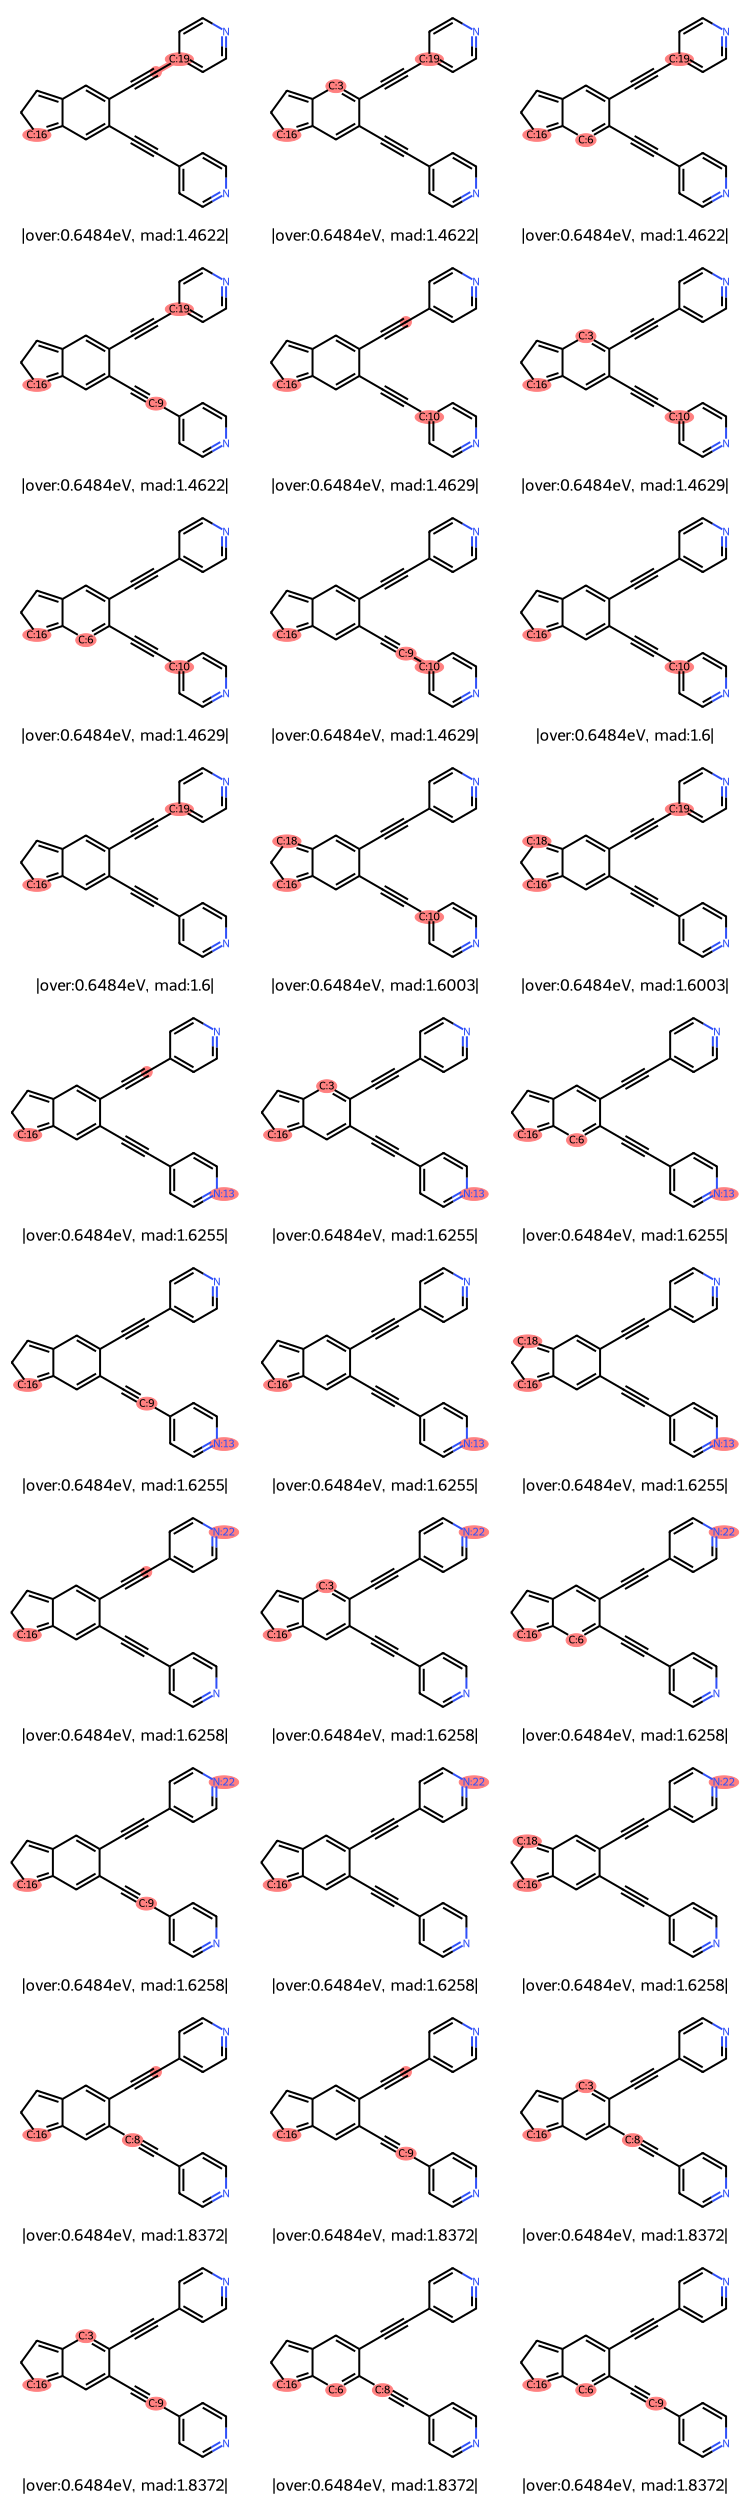

In [197]:
Draw.MolsToGridImage(ms, legends=l, highlightAtomLists=activesites[unraveled_argsorted_overpot_then_madf].tolist(), subImgSize=(250,250))

----

In [ ]:
def free_energy(es_i, eoh_i, eo_i, eooh_i):
    dg1 = (eoh_i - es_i) + dG1_CORR
    dg2 = (eo_i - eoh_i) + dG2_CORR
    dg3 = (eooh_i - eo_i) + dG3_CORR
    dg4 = (es_i - eooh_i) + dG4_CORR

    return np.array((dg1, dg2, dg3, dg4))

In [ ]:
def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

mads = []
indxs = []

for config_indx, energies in enumerated_product(eoh, eo, eooh):
    eoh_i, eo_i, eooh_i = energies
    gs = free_energy(es, eoh_i, eo_i, eooh_i)
    mad_ = (abs(gs-1.23)).sum() #mean absolute diff
    #msd = np.linalg.norm(gs-1.23) #mean squared diff
    mads.append(mad_)
    indxs.append(config_indx)

In [ ]:
# iis = indxs[mads.index(min(mads))]
# iis_as = int(oh[iis[0]].info['active_sites'][0]), int(o[iis[1]].info['active_sites'][0]), int(ooh[iis[2]].info['active_sites'][0])

In [ ]:
free_energy(es, oh[iis[0]].info['energy'], o[iis[1]].info['energy'], ooh[iis[2]].info['energy'])

In [ ]:
mol.GetAtomWithIdx(oh[iis[0]].info['active_sites'][0]).SetProp('atomNote', 'OH')
mol.GetAtomWithIdx(2).SetProp('atomNote', 'O')
mol.GetAtomWithIdx(2).SetProp('atomNote', 'OOH')

In [ ]:
def mol_with_atom_index(mol, indices=None):
    if indices is not None:
        
    
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [ ]:
oh[iis[0]].info['active_sites'][0]

In [ ]:
m = deepcopy(rdkit_smi)
m.GetAtomWithIdx(iis_as[0]).SetProp('atomNote', 'OH')
m.GetAtomWithIdx(iis_as[1]).SetProp('atomNote', 'O')
m.GetAtomWithIdx(iis_as[2]).SetProp('atomNote', 'OOH')
m.__sssAtoms = [*iis_as]
m

-----

In [ ]:
eoh, eo = fill_na(eoh, eo)
eo, eooh = fill_na(eo, eooh)

so, soh = fill_na(so, soh)
sooh, so = fill_na(sooh, so)

ho, hoh = fill_na(ho, hoh)
hooh, ho = fill_na(hooh, ho)

go, goh = fill_na(go, goh)
gooh, go = fill_na(gooh, go)

In [ ]:
e1 = eoh - sub.info['energy']
e2 = pairwise_differences(eoh, eo)
e3 = pairwise_differences(eo, eooh)
e4 = sub.info['energy'] - eooh

In [ ]:
e1_min_indx = np.unravel_index(np.nanargmin(e1), e1.shape)
e2_min_indx = np.unravel_index(np.nanargmin(e2), e2.shape)
e3_min_indx = np.unravel_index(np.nanargmin(e3), e3.shape)
e4_min_indx = np.unravel_index(np.nanargmin(e4), e4.shape)

In [ ]:
# active_sites_configsOH[e1_min_indx], active_sites_configsO[e2_min_indx[0]], active_sites_configsOOH[e3_min_indx[0]]

Pairwise Energy Differences

In [ ]:
# abs()
pwed_OH = pdist(energiesOH[:, None])
pwed_O = pdist(energiesO[:, None])
pwed_OOH = pdist(energiesOOH[:, None])

# diff
pwed_OH_d = pairwise_differences(eoh, eoh, k=1, flatten=True)
pwed_O_d = pairwise_differences(eo, eo, k=1, flatten=True)
pwed_OOH_d = pairwise_differences(eooh, eooh, k=1, flatten=True)

In [ ]:
b = 20
a = 0.5

plt.hist(pwed_OH, bins=b, color='r', alpha=a, label='OH', density=True)
plt.hist(pwed_O, bins=b, color='b', alpha=a, label='O', density=True)
plt.hist(pwed_OOH, bins=b, color='g', alpha=a, label='OOH', density=True)
plt.legend()

In [ ]:
b = 20
a = 0.5

plt.hist(pwed_OH_d, bins=b, color='r', alpha=a, label='OH', density=True)
plt.hist(pwed_O_d, bins=b, color='b', alpha=a, label='O', density=True)
plt.hist(pwed_OOH_d, bins=b, color='g', alpha=a, label='OOH', density=True)
plt.legend()

Once bound, its unlikely that the intermediates migrate to other sites (especially the case for the strongly bound O intermediate). But they don't necessarily have to migrate to another site BEFORE participating in the next OER step; going from OH* -> O** + 0.5 H2 could happen in presumable one concerted step (a step along the saddle point seam of the PES).

Also, its probably not enough to find optimal configurations sequentially and piece them together as done in the past.
One O* intermediate might be suitable for dG2 but not for dG3...you might just have to enumerate all possibilities and pick the combos that minimize the total free energy (sum of dGi, for i=1...4). Something to look into: perhaps pairwise energy differences could be informative, especially if we need to calculate ZPE for each adsorbate which would be expensive. See how zpe changes

Before analyzing free energy differences, we should include the entropy of intermediates into the free energy expressions

In [ ]:
so, soh = fill_na(so, soh)
sooh, so = fill_na(sooh, so)

ho, hoh = fill_na(ho, hoh)
hooh, ho = fill_na(hooh, ho)

go, goh = fill_na(go, goh)
gooh, go = fill_na(gooh, go)

In [ ]:
s1 = soh - sub.info['entropy']
s2 = pairwise_differences(soh, so)
s3 = pairwise_differences(so, sooh)
s4 = sub.info['entropy'] - sooh

h1 = hoh - sub.info['enthalpy']
h2 = pairwise_differences(hoh, ho)
h3 = pairwise_differences(ho, hooh)
h4 = sub.info['enthalpy'] - hooh

g1 = hoh - sub.info['free_energy']
g2 = pairwise_differences(goh, go)
g3 = pairwise_differences(go, gooh)
g4 = sub.info['free_energy'] - gooh

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].hist(s1, bins=b//2, label='dS1', alpha=a, density=True, color='red')
# ax[1].hist(s2, bins=b, label='dS2', alpha=a, density=True, color='blue')
ax[1].hist(s3, bins=b, label='dS3', alpha=a, density=True, color='green')
# ax[0].hist(s4, bins=b, label='dS4', alpha=a, density=True, color='orange')
ax[0].legend()
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].hist(h1, bins=b//2, label='dH1', alpha=a, density=True, color='red')
ax[1].hist(h2, bins=b, label='dH2', alpha=a, density=True, color='blue')
ax[0].hist(h2, bins=b, label='dH3', alpha=a, density=True, color='green')
ax[1].hist(h3, bins=b, label='dH4', alpha=a, density=True, color='orange')
ax[0].legend()
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].hist(g1, bins=b//2, label='dG1', alpha=a, density=True, color='red')
ax[1].hist(g2, bins=b, label='dG2', alpha=a, density=True, color='blue')
ax[1].hist(g3, bins=b, label='dG3', alpha=a, density=True, color='green')
ax[0].hist(g4, bins=b, label='dG4', alpha=a, density=True, color='orange')
ax[0].legend()
ax[1].legend()

#### Sequential active site search

In [ ]:
cs = find_optimal_adsorbate_configurations_sequential(sub, optlevel_low='normal', optlevel_high='vtight', keep_folders=True, multi_process=6)

In [ ]:
cs = multi_run(cs, runtype='hess', calc_kwargs=calc_params, multi_process=3)
gs = calculate_free_energies(sub, *cs)
gs

In [ ]:
free_energy_diagram(gs)

-----

In [ ]:
# as_combos = [[[sub[ai].symbol, sub[av].symbol] for ai in active_sites_configsOH] for av in active_sites_configsOH]

In [ ]:
# unique_symbols = sorted(list(set(sub.get_chemical_symbols())))
# unique_symbols.remove('H')

In [ ]:
# migration_combos = [(us, us) for us in unique_symbols] + [p for p in itertools.combinations(unique_symbols, 2)]
# migration_perms = [[us, us] for us in unique_symbols] + [p for p in itertools.permutations(unique_symbols, 2)]

# Fukui

In [ ]:
# r_sub_confs = relax_configurations(sub_confs, sub.info['calc_params'], {"trajectory":None, "fmax":0.0005}, multi_process=8)

# for i, c in enumerate(cs):
#     c.write(f'{i}.xyz')
    
# sub.write('s.xyz')

# c0 = read('0.xyz')
# c1 = read('1.xyz')
# c2 = read('2.xyz')

In [ ]:
from osc_discovery.photocatalysis.adsorption.constants import OH
from osc_discovery.photocatalysis.adsorption.building import build_configuration_from_site

In [ ]:
configsOH = []
for site in range(sub.info['nonH_count']):
    configsOH += build_configuration_from_site(OH, sub, site, [], f=1.4)

configsOH_relaxed = relax_configurations(configsOH, sub.info['calc_params'], {
    'trajectory':None, "fmax":0.5}, multi_process=2)

configsOH_filtered = filter_configurations(configsOH_relaxed, sub)

In [ ]:
energies = np.array([config.info['energy'] for config in configsOH_filtered])
active_sites_configsOH = np.array([config.info['active_sites'][0] for config in configsOH_filtered])
indx_sorted = energies.argsort()
active_sites_ranked = active_sites_configsOH[indx_sorted]

In [ ]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [ ]:
from xtb.ase.calculator import XTB

In [ ]:
sub.calc = XTB(**sub.info['calc_params'])

In [ ]:
qs = sub.get_charges()

In [ ]:
from ase.visualize.plot import plot_atoms

In [ ]:
qs_norm = (qs - qs.min()) / (qs.max() - qs.min())
cmap = plt.get_cmap('Greys')
colors = cmap(qs_norm)

In [ ]:
plot_atoms(sub, colors=colors)

In [ ]:
mol_with_atom_index(rdkit_smi)

In [ ]:
active_sites_ranked